# Resize Dataset

In [ ]:
from PIL import Image
from multiprocessing import Pool
from functools import partial
import glob

In [ ]:
# Dataset
# https://www.kaggle.com/paramaggarwal/fashion-product-images-dataset

srcPath = './img/fashion-dataset/images/'
savePath = './img/fashion-dataset/224/'

In [ ]:
def resizeImage(imgPath, size=(224,224)):
    src = Image.open(imgPath)
    return src.resize(size)

def resizeAndSaveImage(imgPath, savePath):
    imgName = imgPath.split('/')[-1]
    resizedImg = resizeImage(imgPath)
    resizedImg.save('{}{}'.format(savePath, imgName))

In [ ]:
with Pool(processes=8) as pool:
    pool.map(partial(resizeAndSaveImage, savePath=savePath), glob.glob('{}*'.format(srcPath)))

# Make datasetCsv

In [2]:
import glob
import pandas as pd
import numpy as np

In [3]:
dataPath = './img/fashionDataset/224/'
labelPath = './img/fashionDataset/styles.csv'
datasetCsv = './img/fashionDataset/dataset224.csv'

In [4]:
allLabels = pd.read_csv(labelPath)

In [5]:
allLabels.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [7]:
allImgNames = !ls {dataPath}
allImgNames = pd.DataFrame(allImgNames, columns=['fileName'])
allImgNames = pd.DataFrame(allImgNames.fileName.str.split('.').tolist(), columns=['fileName','extension'], dtype=np.int64)
availableLabels = pd.merge(allImgNames, allLabels, left_on='fileName', right_on='id')
pd.unique(availableLabels.subCategory)

array(['Bottomwear', 'Topwear', 'Shoes', 'Sandal', 'Flip Flops',
       'Watches', 'Bags', 'Belts', 'Dress', 'Headwear', 'Innerwear',
       'Scarves', 'Ties', 'Free Gifts', 'Socks', 'Wallets',
       'Shoe Accessories', 'Stoles', 'Apparel Set', 'Mufflers',
       'Loungewear and Nightwear', 'Cufflinks', 'Jewellery', 'Umbrellas',
       'Eyewear', 'Sports Equipment', 'Water Bottle', 'Accessories',
       'Fragrance', 'Gloves', 'Perfumes', 'Saree', 'Bath and Body',
       'Vouchers', 'Nails', 'Eyes', 'Lips', 'Makeup',
       'Sports Accessories', 'Skin Care', 'Skin', 'Beauty Accessories',
       'Hair', 'Wristbands'], dtype=object)

In [8]:
# get useable category
subCategorySummary = availableLabels.groupby('subCategory').count().reset_index()
subCategorySummary = subCategorySummary[['subCategory','fileName']]
useSubCategory = subCategorySummary[subCategorySummary['fileName'] > 500]['subCategory']

In [10]:
# make fileName label map
dataset = availableLabels[availableLabels['subCategory'].isin(list(useSubCategory))][['fileName','subCategory']]
dataset['path'] = dataPath
dataset['ext'] = '.jpg'
dataset = dataset.astype(str)
dataset['fullPath'] = dataset['path'] + dataset['fileName'] + dataset['ext']
dataset.head()

,fileName,subCategory,path,ext,fullPath
0,10004,Bottomwear,./img/fashionDataset/224/,.jpg,./img/fashionDataset/224/10004.jpg
1,10005,Topwear,./img/fashionDataset/224/,.jpg,./img/fashionDataset/224/10005.jpg
2,10008,Topwear,./img/fashionDataset/224/,.jpg,./img/fashionDataset/224/10008.jpg
3,10009,Topwear,./img/fashionDataset/224/,.jpg,./img/fashionDataset/224/10009.jpg
4,10010,Topwear,./img/fashionDataset/224/,.jpg,./img/fashionDataset/224/10010.jpg


In [11]:
# change label to number
labelMap = pd.DataFrame(pd.unique(dataset.subCategory)).reset_index()
labelMap.columns = ['label', 'subCategory']
labelMap

,label,subCategory
0,0,Bottomwear
1,1,Topwear
2,2,Shoes
3,3,Sandal
4,4,Flip Flops
5,5,Watches
6,6,Bags
7,7,Belts
8,8,Innerwear
9,9,Wallets


In [12]:
# save csv
dataset = pd.merge(dataset, labelMap, on='subCategory')
dataset[['fullPath','label']].to_csv(datasetCsv, index=False)

# Make TFRecord

In [14]:
import tensorflow as tf
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm_notebook as tqdm

In [15]:
tfrecordPath = './img/fashionDataset/tfrecord/'
tfrecordFilePath = '{}dataset224.tfrecord'.format(tfrecordPath)

In [16]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

In [17]:
# shuffle dataset
datasetFile = pd.read_csv(datasetCsv)
datasetFile = datasetFile.sample(frac=1).reset_index(drop=True)

In [18]:
# make writer
writer = tf.io.TFRecordWriter(
    tfrecordFilePath,
    options=tf.io.TFRecordOptions(compression_type=tf.io.TFRecordCompressionType.GZIP)
)

In [19]:
i = 0
for imgPath, label in datasetFile.itertuples(index=False):
    fileName = imgPath.split('/')[-1].split('.')[0]
    image_raw = open(imgPath, 'rb').read()
    example = tf.train.Example(features=tf.train.Features(feature={
        'index': _int64_feature(i),
        'name': _int64_feature(int(fileName)),
        'label': _int64_feature(int(label)),
        'image': _bytes_feature(image_raw)
        }))
    writer.write(example.SerializeToString())
    i += 1

In [20]:
writer.close()

## TFRecord Test 

In [21]:
def _parse_function(example_proto):
    features = { 
        'index': tf.FixedLenFeature((), tf.int64, default_value=0),
        'name': tf.FixedLenFeature((), tf.int64, default_value=0),
        'label': tf.FixedLenFeature((), tf.int64, default_value=0),
        'image': tf.FixedLenFeature((), tf.string, default_value='')
    }
    parsed_features = tf.parse_single_example(example_proto, features)
    image_decoded = tf.image.decode_jpeg(parsed_features['image'])
    return parsed_features['index'], image_decoded, parsed_features['label']

In [22]:
dataset = tf.data.TFRecordDataset(tfrecordFilePath, compression_type='GZIP')
dataset = dataset.map(_parse_function)
dataset = dataset.shuffle(buffer_size=25000, reshuffle_each_iteration=True)
dataset = dataset.batch(1)
iterator = dataset.make_initializable_iterator()
next_element = iterator.get_next()
dataset_init_op = iterator.initializer

In [23]:
history = []
step = 0
with tf.Session() as sess:
    for epoch in range(1):
        sess.run(dataset_init_op)
        while True: # tf.errors.OutOfRangeErrorを吐くまでループ
            try:
                res = sess.run(next_element)
                #print(step,res[1])
                #print(res[1])
                step += 1
                history.append([step, res[2], res[0]])
            except tf.errors.OutOfRangeError:
                break

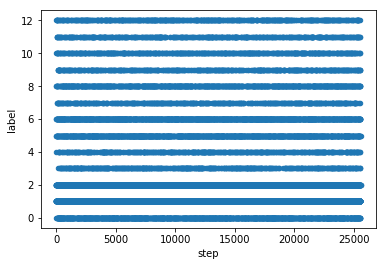

In [27]:
# check label variation of TFRecord
res = pd.DataFrame(np.array(history))
res.columns = ['step', 'label','index']
res.plot(kind='scatter', x='step', y='label')

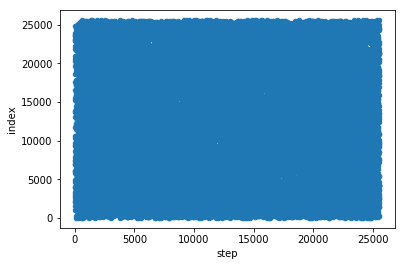

In [28]:
# check index variation of TFRecord
res.plot(kind='scatter', x='step', y='index')